In [75]:
# Put all library imports in this block!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [24]:
# Data prep
data_vintage = pd.read_csv('2025-08-MD.csv')
data_vintage = data_vintage[['sasdate', 'UNRATE', 'INDPRO']]
data_vintage = data_vintage.iloc[1:].copy()

df_log_diff = pd.DataFrame()
df_log_diff['DATE'] = pd.to_datetime(data_vintage['sasdate'])
df_log_diff['UNRATE'] = np.log(data_vintage['UNRATE']).diff()
df_log_diff['INDPRO'] = np.log(data_vintage['INDPRO']).diff()
df_log_diff = df_log_diff.iloc[1:].copy()

display(df_log_diff.head())

,DATE,UNRATE,INDPRO
2,1959-02-01,-0.016807,0.019395
3,1959-03-01,-0.052186,0.014300
4,1959-04-01,-0.074108,0.021080
5,1959-05-01,-0.019418,0.014954
6,1959-06-01,-0.019803,0.001137


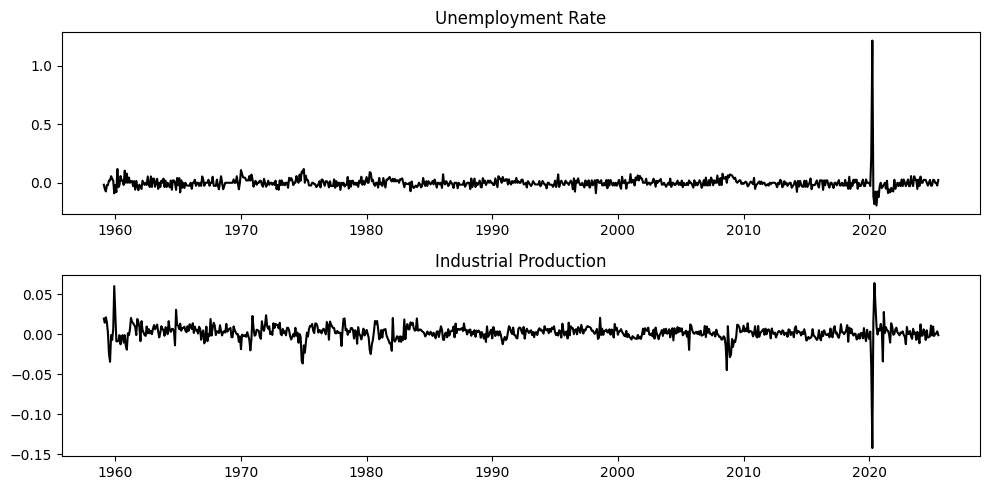

In [26]:
# Plotting log differences
plt.figure(figsize=(10,5))

## Unemployment rate
plt.subplot(2,1,1)
plt.plot(df_log_diff['DATE'], df_log_diff['UNRATE'], color='black')
plt.title('Unemployment Rate')

## Industrial production
plt.subplot(2,1,2)
plt.plot(df_log_diff['DATE'], df_log_diff['INDPRO'], color='black')
plt.title('Industrial Production')

plt.tight_layout()
plt.show()

# Question 2

In [125]:
model_names = ('AR(1)', 'SESTAR', 'STAR')

def get_total_loss(theta, model_name, x, y = None):
  mu, delta, gamma, alpha, beta = theta
  x = np.asarray(x)
  y = np.asarray(y)

  div = 0

  if model_name == 'SESTAR':
    div = gamma / (1 + np.exp(alpha + beta * x[:-1]))
  elif model_name == 'STAR':
    div = gamma / (1 + np.exp(alpha + beta * y[:-1]))

  resid = x[1:] - mu - (delta + div) * x[:-1]

  return np.sum(resid**2)

In [126]:
# Test point for total loss (OK)
theta_star = (0, 0.3, 1, 0, 2)

for model in model_names:
  total_loss = get_total_loss(theta_star, model, df_log_diff['UNRATE'], df_log_diff['INDPRO'])
  print(f'Total Loss for {model}: {total_loss:.6f}')

Total Loss for AR(1): 2.420311
Total Loss for SESTAR: 2.687785
Total Loss for STAR: 3.652962


In [127]:
# Results for Q2

theta_tilde = (0, 0.1, 2, 0, 3)
results_Q2 = {}

for model in model_names:
  total_loss = get_total_loss(theta_tilde, model, df_log_diff['UNRATE'], df_log_diff['INDPRO'])
  print(f'Total Loss for {model}: {total_loss:.6f}')

  results_Q2[model] = {
      'total_loss': total_loss
  }

Total Loss for AR(1): 2.329560
Total Loss for SESTAR: 2.847958
Total Loss for STAR: 5.435420


# Question 3

In [133]:
def estimate_model(theta_init, model_name, x, y=None):

  result = minimize(get_total_loss,
                    theta_init,
                    args=(model_name, x, y),
                    method='L-BFGS-B')

  if model_name not in model_names:
    raise ValueError('Invalid model name specified.')

  if not result.success:
    print(f'\nWarning: Optimization failed for {model_name}.')
    print(f'Message: {result.message}\n')
  else:
    print(f'\nOptimization successful for {model_name}. Total Loss: {result.fun:.6f}\n')

  return result.x, result.fun

def fit_values(theta, model_name, x, y=None):
  mu, delta, gamma, alpha, beta = theta
  x = np.asarray(x)
  if y is not None: y = np.asarray(y)

  div = np.zeros_like(x)
  if model_name == 'SESTAR':
    div[1:] = gamma / (1 + np.exp(alpha + beta * x[:-1]))
  elif model_name == 'STAR':
    div[1:] = gamma / (1 + np.exp(alpha + beta * y[:-1]))

  return mu + (delta + div) * x


Initial loss: 2.420311

Optimization successful for AR(1). Total Loss: 2.329415



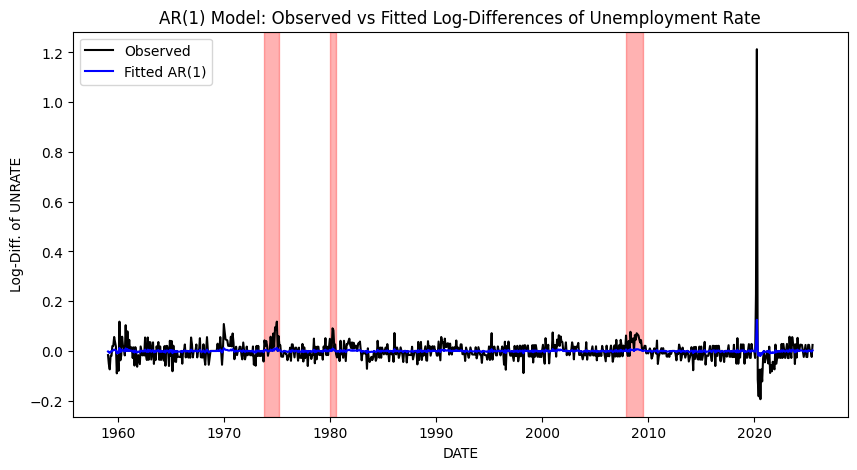


Optimization successful for SESTAR. Total Loss: 2.175516



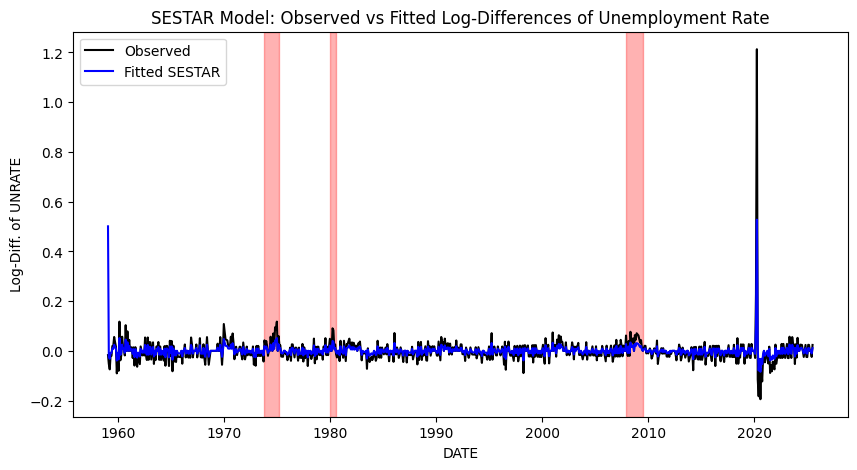


Optimization successful for STAR. Total Loss: 2.175517



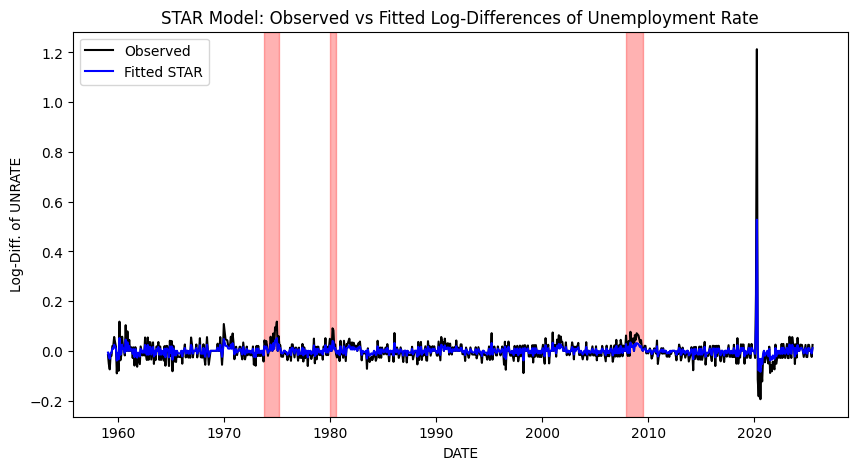

In [148]:
# Results for Q3

theta_init = (0, 0.3, 0, 0, 6)
date = df_log_diff['DATE']
x = df_log_diff['UNRATE']
y = df_log_diff['INDPRO']

recessions_periods = [
    ('1973-11-01', '1975-03-31'),
    ('1980-01-01', '1980-07-31'),
    ('2007-12-01', '2009-06-30')
]

results_Q3 = {}

loss_init = get_total_loss(theta_init, model_name, x, y)
print(f'Initial loss: {loss_init:.6f}')

for model in model_names:
  theta_optim, loss_optim = estimate_model(theta_init, model, x, y)
  results_Q3[model] = {
      'theta': theta_optim,
      'total_loss': loss_optim
  }

  x_fitted = fit_values(theta_optim, model, x, y)

  # Plotting actual vs fitted values
  plt.figure(figsize=(10, 5))
  plt.plot(date, x, label='Observed', color='black')
  plt.plot(date, x_fitted, label=f'Fitted {model}', color='blue')

  for start, end in recessions_periods:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='red', alpha=0.3)

  plt.title(f'{model} Model: Observed vs Fitted Log-Differences of Unemployment Rate')
  plt.xlabel('DATE')
  plt.ylabel('Log-Diff. of UNRATE')
  plt.legend()
  plt.show()

  # Uncomment to store plot
  # plt.savefig(f'UNRATE_fitted_{model}.png', dpi=300)

  plt.close()